In [212]:
"""Volume 2: Non-negative Matrix Factorization."""

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import os
from imageio import imread
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error as mse

In [213]:
import numpy as np

random_matrix = np.random.random((5,5))
x = cp.Variable((5,5))
x.value = random_matrix

print(x.value)

[[0.17760058 0.08676703 0.02531968 0.78156786 0.090455  ]
 [0.73975407 0.60202143 0.70452663 0.55251578 0.96216436]
 [0.38898592 0.81150909 0.66020629 0.92652008 0.5485268 ]
 [0.26112314 0.47888107 0.59502555 0.93585236 0.80860272]
 [0.87390259 0.62210996 0.56451081 0.97209262 0.11483622]]


In [215]:
#Problems 1-2
class NMFRecommender:

    def __init__(self,random_state=15,rank=3,maxiter=200,tol=1e-3):
        """The parameter values for the algorithm"""

        # Set parameters
        self.random_state = random_state
        self.rank = rank
        self.maxiter = maxiter
        self.tol = tol
        
    
    def initialize_matrices(self,m,n):
        """randomly initialize the W and H matrices,"""

        # Set random generator
        np.random.seed(self.random_state)

        # Initialize W, H
        W = np.random.rand(m,self.rank)
        H = np.random.rand(self.rank,n)
        self.W = W
        self.H = H
        return self.W, self.H

    def fit(self,V):
        """Fits W and H weight matrices using CVXPY"""

        # Set W, H and iterator
        self.W, self.H = self.initialize_matrices(V.shape[0], V.shape[1])
        done = False

        # Initialize CVXPY variables
        W = cp.Variable(self.W.shape, nonneg = True)
        H = cp.Variable(self.H.shape, nonneg = True)

        # Run maxiter times
        for i in range(self.maxiter):
            done = True

            # Run CVXPY problem for W
            cp.Problem(cp.Minimize(cp.norm(V - W @ self.H, p = 'fro'))).solve()
            if np.linalg.norm(W.value - self.W) > self.tol:
                done = False
            self.W = W.value.copy()

            # Run CVXPY problem for H
            cp.Problem(cp.Minimize(cp.norm(V - self.W @ H, p = 'fro'))).solve()
            if np.linalg.norm(H.value - self.H) > self.tol:
                done = False
            self.H = H.value.copy()

            # Break if we are done
            if done == True:
                break

        # Return W and H
        return self.W, self.H

    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""

        # Reconstruct V matrix
        return self.W @ self.H



In [216]:
nmf = NMFRecommender()

print(nmf.initialize_matrices(2,3))

(array([[0.8488177 , 0.17889592, 0.05436321],
       [0.36153845, 0.27540093, 0.53000022]]), array([[0.30591892, 0.30447436, 0.11174128],
       [0.24989901, 0.9176299 , 0.26414685],
       [0.71777369, 0.86571503, 0.80707948]]))


In [ ]:
# Create two scalar optimization variables
x = cp.Variable()
y = cp.Variable()

# Create two constraints
constraints = [x+ y == 1, x - y >= 1]

# Form objective
obj = cp.Minimize((x-y)**2)

# Form and solve problem
prob = cp.Problem(obj, constraints)
prob.solve()

# Print the status of the solution
print(prob.status)


optimal


In [217]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    
    # Initialize V
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1 ,2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )

    # Run NMF on this matrix
    nmf = NMFRecommender(rank = 2)
    nmf.initialize_matrices(5,6)

    # Return W, H, and the number of people who have higher weights in component 2 than in component 1
    return nmf.fit(V), np.sum(nmf.H[0] < nmf.H[1])
    

In [1]:
print(prob3())

NameError: name 'prob3' is not defined

In [ ]:

#get data
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

def show(image, m=200, n=180, plt_show=False):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    #scale image
    image = image / 255
    #reshape image
    image = np.reshape(image,(m,n))
    #show image
    plt.imshow(image,cmap = "gray")
    
    if plt_show:
        plt.show()


In [ ]:
def prob4():
    """
        Gridsearch over rank, alpha and l1_ratio values to reconstruct 
        image using NMF. Plot all reconstructed images.
    """
    # Initialize plot and variables
    plt.figure(figsize = (12,10))
    faces = get_faces()
    error = 1e12
    best_values = (75,-1,-1)
    i = 0

    # Decompose using NMF for combinations of alpha and l1_ratio
    for alph in [0,0.2,0.5]:
        for l1_rat in [0, 10**-5, 1]:
            # Run NMF model
            model = NMF(n_components= 75, init = 'random', random_state = 0, alpha = alph, l1_ratio= l1_rat)
            W = model.fit_transform(faces)
            H = model.components_

            # Find best value
            diff = np.linalg.norm(faces[:,2]- W @ H[:,2])
            if diff < error:
                error = diff
                best_values = (75, alph, l1_rat)
            
            # Plot all the reconstructed images
            plt.subplot(331+i)
            V = W @ H[:,2]
            show(V)
            plt.title(f"n_components = 75, alpha = {alph}, l1_ratio = {l1_rat}")
            i += 1

    # Finish plotting
    plt.tight_layout()
    plt.show()
    return best_values


    
    

    


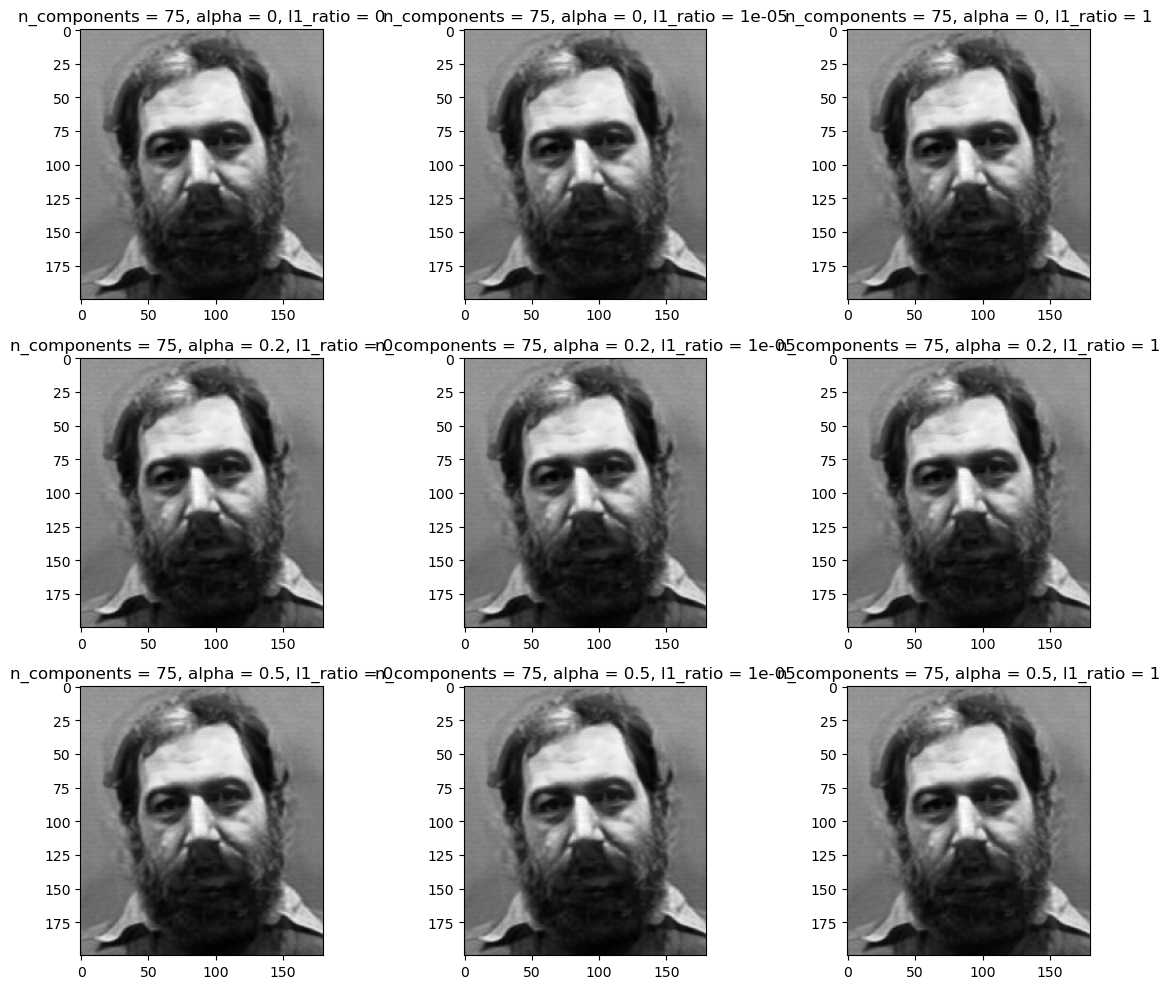

(75, 0.5, 1e-05)


In [ ]:
print(prob4())

In [ ]:
def prob5():
    '''
        find the 10 basis faces with the largest coefficients 
        corresponding to the the second and twelfth face in the dataset. 
        Plot these basis faces along with the original image using 
        subplots
    '''

    # Get faces
    face2, face12 = get_faces().T[1], get_faces().T[11]

    # Show original images
    faces = get_faces()
    show(face2, plt_show = True)
    show(face12, plt_show = True)

    # Do NMF 
    N = NMF(n_components = 75, alpha = 0.5, l1_ratio = 1e-05)
    W = N.fit_transform(faces)
    H = N.components_

    # Sort the basis vectors
    close2 = np.argsort(H[:,1])[-10:]
    close12 = np.argsort(H[:,11])[-10:]

    # Show all the basis vectors
    for i,j in zip(close2, close12):
        show(W[:,i], plt_show = True)

        show(W[:,j], plt_show = True)

    # Show plots
    plt.show()     







    

    

    

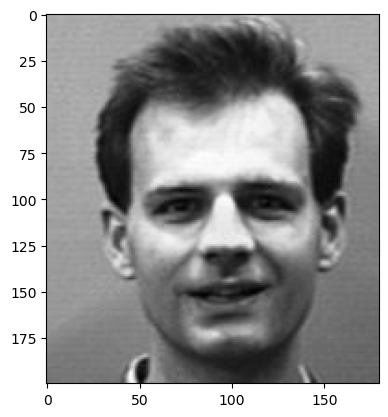

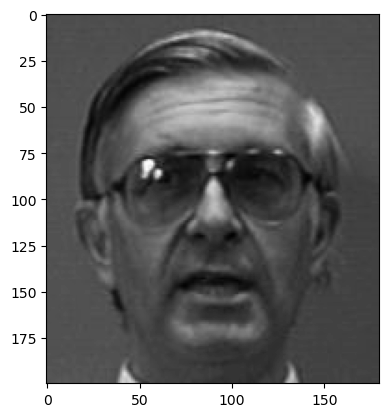

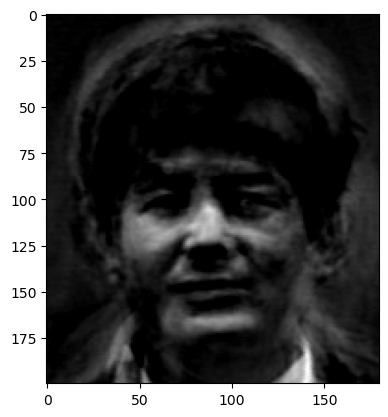

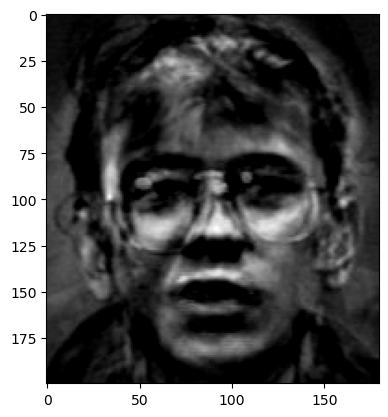

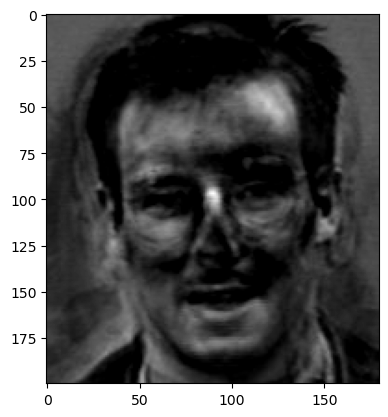

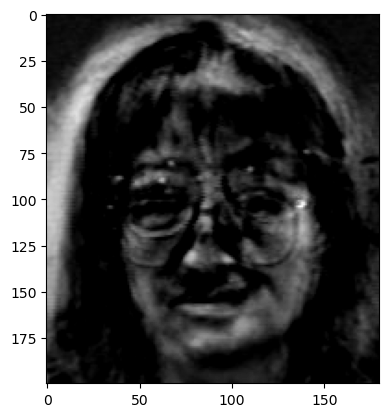

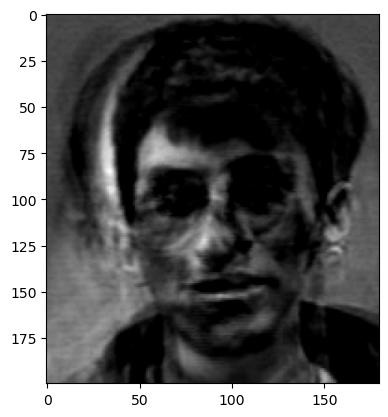

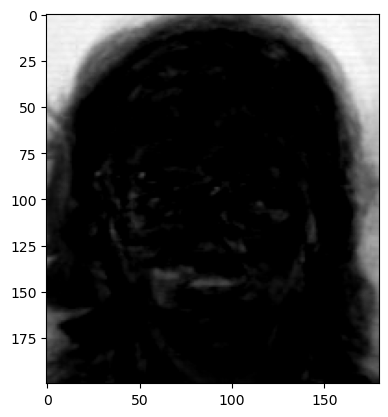

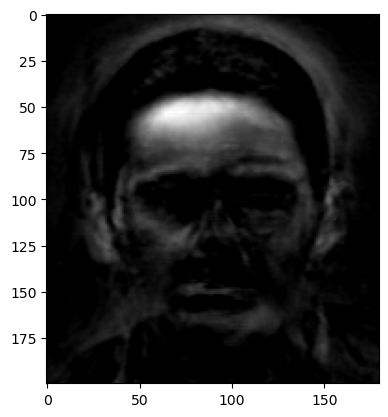

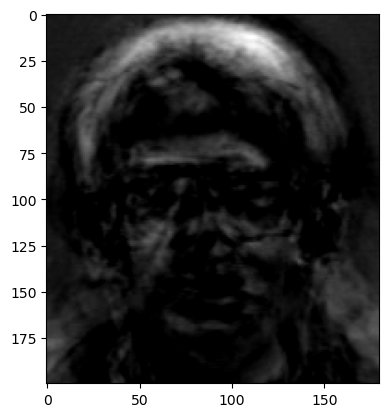

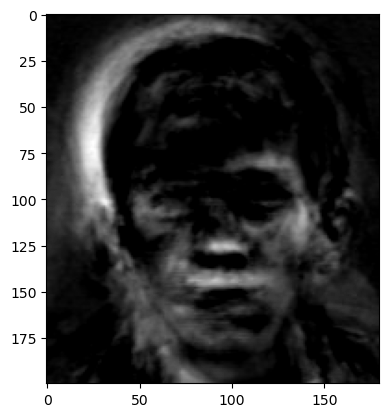

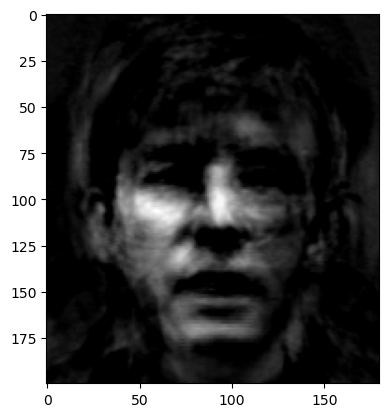

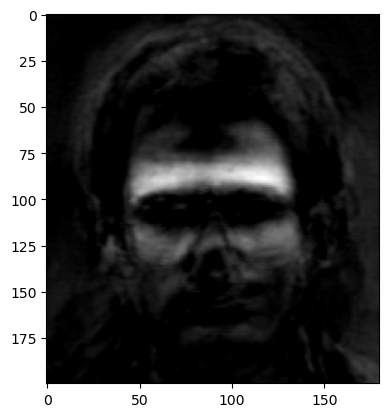

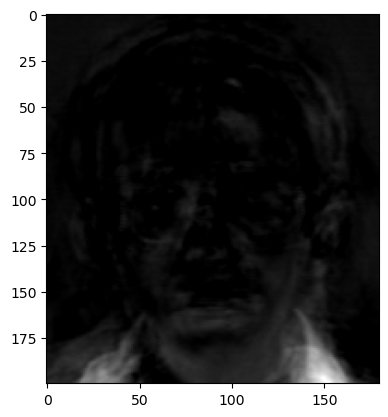

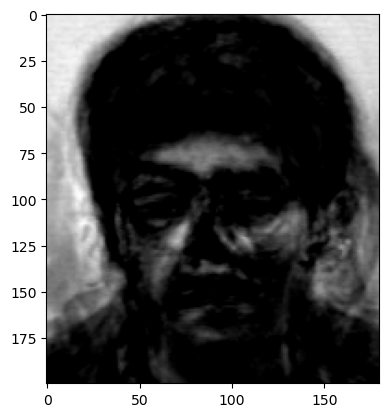

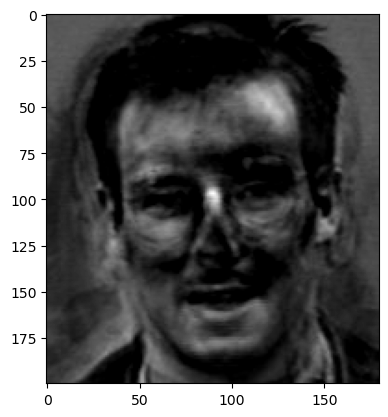

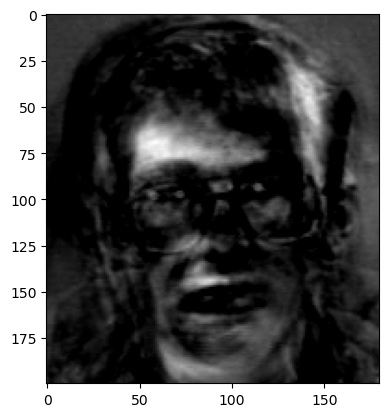

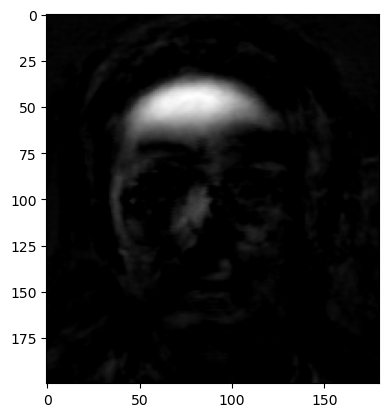

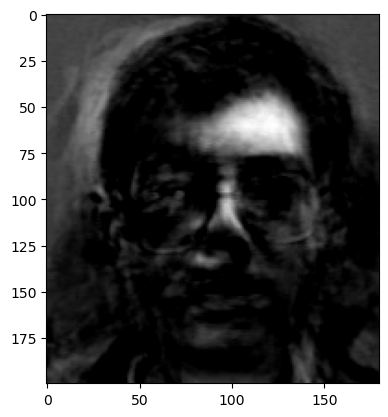

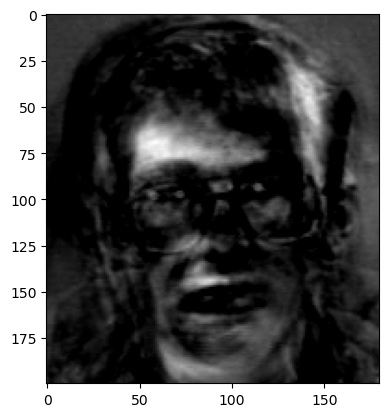

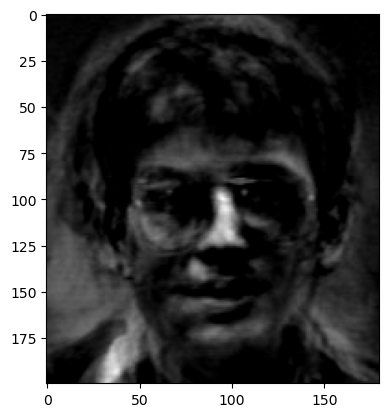

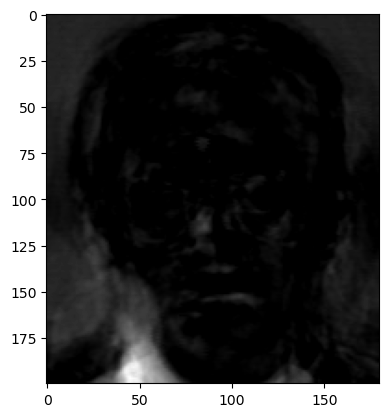

None


In [ ]:
print(prob5())

We see that all of these basis faces highlight a different part of the face!

<Figure size 640x480 with 0 Axes>

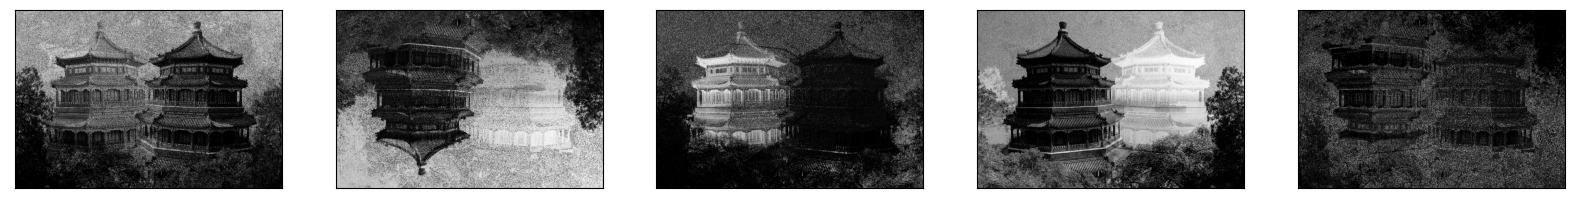

In [ ]:
from sklearn.datasets import load_sample_images
import numpy as np

# function to convert colored image to gray scale image
def gray_convert(rgb):
    r,g,b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

# Load in sample images
dataset = load_sample_images()
# Grab the first image
image = dataset.images[0]

# Convert Image to Gray Scale
image = gray_convert(image)

# Get augmentations for additional images
flipLR = np.fliplr(image)
flipUP = np.flipud(image)

# Create Matrix V
images = [np.ravel(image), np.ravel(flipLR), np.ravel(flipUP)]
images = np.transpose(images)

# Decompose using NMF
model = NMF(n_components = 5, max_iter = 1000)
W = model.fit_transform(images)
H = model.components_

# Plot Basis Images
plt.subplots_adjust(wspace = 0.02, hspace = 0.05)
plt.figure(figsize = (20,8))
for i in range(W.shape[1]):
    plt.subplot(1,5, i + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(np.reshape(W[:,i], (427,640)), cmap = 'gray')